In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import scipy.signal
import time
import cv2
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices("GPU")

[]

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

In [4]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [5]:
num_actions = 3
observation_dimensions = (128, 128, 3)

In [6]:
def Model(actions):
    inp = keras.layers.Input( shape=observation_dimensions )
    x = keras.layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', 
                            padding='same', activation="relu")(inp)
    
    x = keras.layers.AveragePooling2D( (2,2) )(x)
    x = keras.layers.Conv2D(filters=8, kernel_size=(3,3), kernel_initializer='he_normal', 
                            padding='same', activation="relu")(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    
    x1 = keras.layers.Dense(64, activation="relu")(x)
    x1 = keras.layers.Dense(actions, activation="softmax", name="throttle")(x1)
        
    return keras.models.Model( inp, x1 )

In [7]:
steer_model = Model(3)
steer_model.compile( optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

acc_model = Model(2)
acc_model.compile( optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

In [8]:
import os

In [9]:
data = pd.read_csv("action_took.csv").drop_duplicates()
print(data.shape)
data = data[ data.iloc[:,0] != "0" ]
data.shape

(605, 3)


(604, 3)

In [10]:
up_down_target = data.iloc[:,1]
up_down_target.iloc[data.iloc[:,1] == -1] = 0
up_down_target.value_counts()

/opt/anaconda3/envs/c557/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


1    518
0     86
Name: 1, dtype: int64

In [11]:
left_right_target = data.iloc[:,2]
left_right_target.value_counts()

 0    304
-1    198
 1    102
Name: 2, dtype: int64

In [12]:
images = []
for img in data.iloc[:,0]:
    images.append(cv2.imread(img).reshape((-1,128,128,3)) )
images = np.concatenate(images, axis=0)
images.shape

(604, 128, 128, 3)

In [13]:
up_down_target = (up_down_target).values
left_right_target = (left_right_target+1).values

In [14]:
target_ud = np.zeros( (len(images), 2) )
target_lr = np.zeros( (len(images), 3) )
target_ud.shape, target_lr.shape

((604, 2), (604, 3))

In [15]:
for i in range(len(up_down_target)):
    target_ud[i][ up_down_target[i] ] = 1
    
for i in range(len(left_right_target)):
    target_lr[i][ left_right_target[i] ] = 1

In [16]:
target_ud.sum(axis=0), target_lr.sum(axis=0)

(array([ 86., 518.]), array([198., 304., 102.]))

In [17]:
history_steer = steer_model.fit(images/255, target_lr, validation_split=0.2, batch_size=128, epochs=3)

Epoch 1/3
4/4 [==============================] - 3s 648ms/step - loss: 3.8869 - accuracy: 0.3313 - val_loss: 1.1954 - val_accuracy: 0.6033
Epoch 2/3
4/4 [==============================] - 2s 593ms/step - loss: 1.6731 - accuracy: 0.4638 - val_loss: 0.8909 - val_accuracy: 0.6198
Epoch 3/3
4/4 [==============================] - 2s 598ms/step - loss: 0.8445 - accuracy: 0.6046 - val_loss: 0.6889 - val_accuracy: 0.7355


In [18]:
history_acc = acc_model.fit(images/255, target_ud, validation_split=0.2, batch_size=128, epochs=3)

Epoch 1/3
4/4 [==============================] - 3s 650ms/step - loss: 1.4643 - accuracy: 0.8530 - val_loss: 1.2428 - val_accuracy: 0.7190
Epoch 2/3
4/4 [==============================] - 2s 590ms/step - loss: 0.2778 - accuracy: 0.9151 - val_loss: 0.4562 - val_accuracy: 0.7190
Epoch 3/3
4/4 [==============================] - 2s 607ms/step - loss: 0.1497 - accuracy: 0.9420 - val_loss: 0.7283 - val_accuracy: 0.7190


In [19]:
acc_model.save("acc_model.h5")
steer_model.save("steer_model.h5")

In [20]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")

Text(0.5, 1.0, 'Steer accuracy Metric')

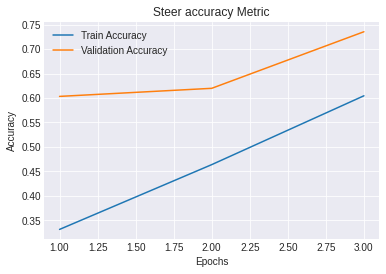

In [21]:
plt.plot( range(1,4), history_steer.history["accuracy"], label="Train Accuracy" )
plt.plot( range(1,4), np.array(history_steer.history["val_accuracy"]), label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Steer accuracy Metric")

Text(0.5, 1.0, 'Steer loss Metric')

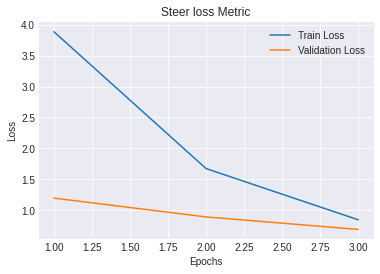

In [22]:
plt.plot( range(1,4), history_steer.history["loss"], label="Train Loss" )
plt.plot( range(1,4), np.array(history_steer.history["val_loss"]), label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Steer loss Metric")

In [23]:
import gym
import gym_carla
import carla 

In [24]:
#WetCloudyNoon, WetSunset, HardRainNoon

In [30]:
params = {
    'number_of_vehicles': 20,
    'number_of_walkers': 30,
    'display_size': 250,  # screen size of bird-eye render
    'display_height' : 512,
    'display_main': True,
    'weather': "WetSunset",
    'max_past_step': 1,  # the number of past steps to draw
    'dt': 0.1,  # time interval between two frames
    'discrete': False,  # whether to use discrete control space
    'discrete_acc': [1.0, 0.0, 1.0],  # discrete value of accelerations
    'discrete_steer': [-1, 0, 1],  # discrete value of steering angles
    'continuous_accel_range': [-3.0, 3.0],  # continuous acceleration range
    'continuous_steer_range': [-0.2, 0.2],  # continuous steering angle range
    'ego_vehicle_filter': 'vehicle.tesla.model3',  # filter for defining ego vehicle
    'address': 'localhost',
    'port': 2000, # connection port
    'town': 'Town02', # which town to simulate
    'task_mode': 'random',  # mode of the task, [random, roundabout (only for Town03)]
    'max_time_episode': 5000,  # maximum timesteps per episode
    'max_waypt': 12,  # maximum number of waypoints
    'obs_range': 32,  # observation range (meter)
    'lidar_bin': 0.125,  # bin size of lidar sensor (meter)
    'd_behind': 12,  # distance behind the ego vehicle (meter)
    'out_lane_thres': 5.0,  # threshold for out of lane
    'desired_speed': 8,  # desired speed (m/s)
    'max_ego_spawn_times': 200,  # maximum times to spawn ego vehicle
    'display_route': True,  # whether to render the desired route50
    'pixor_size': 64,  # size of the pixor labels
    'pixor': False,  # whether to output PIXOR observation 
}

In [31]:
def read_transform(img):
    return img[76:204,76:204,:]/255
env = gym.make('carla-v0', params=params)

connecting to Carla server...
Carla server connected!


In [35]:
observation =  env.reset()
for _ in range(20): observation, _, _, _ = env.step([1.25,0])
done = False
while not done:
    action_ud = np.argmax(acc_model.predict( read_transform(observation['birdeye']).reshape( (1, 128,128,3) ))[0])
    action_lr = np.argmax(steer_model.predict( read_transform(observation['birdeye']).reshape( (1, 128,128,3) ))[0])-1
    observation, _, done, _ = env.step( [1.25*action_ud if action_ud == 1 else -1, action_lr] )